# Bayesian brain model of an attentional phenomenon
Benjamin T. Vincent, [@inferenceLab](https://twitter.com/inferencelab)

This notebook shows how to make calculate predicted performance of an optimal Bayesian observer in a cued localisation task. This is a covert attentional task where participants look at a computer screen:
- They fixate the centre of the screen so that stimuli which later appear are all equidistant from the fovea. 
- A cue appears uniformly randomly in one of N locations before disappearing. 
- The participants have been informed about the validity of the cue in advance. For example, if the cue is 80% valid, then there is an 80% chance that a target object will appear at the cued location and a 20% of being in one of the other N-1 locations. 
- Distractors appear in all other locations. 
- The stimulus items are chosen to be visually similar and to appear for short durations of time, so that there is remaining uncertainty about the target's location.

**The interesting theoretical question is: do participants optimally incorporate sensory information (from the stimuli) and prior beliefs (from the cue)?**

<img src="img/cued localisation.png" width="600">

Vincent (2011) examined how people's performance in a cued localisation task varied depending on how valid the cue was. People's performance was worst when the cue was uninformative - in this case with 4 locations this was when the cue was valid 1/4 of the time. Performance improved when the cue was more predictive of the target location, suggesting that participants did combine their prior beliefs (from the cue) with the likelihood (from the stimuli). However, it was also the case that performance improved when the cue signalled where a target would be _less_ likely to appear. For example, when it was 0% valid the target was never at the cued location. Participants were able to use the information from the cue so as to update their beliefs that the targets were more likely to occur in the remaining locations, which lead to enhanced performance.

<img src="img/vincent2011.png" width="400">

There were some interesting peculiarities about the participant's performance which indicated that while they combined the cue-derived prior beliefs and the stimulus-based likelihood, they seemed to have biases in their beliefs akin to those seen in Prospect Theory. 

In this notebook, we will ignore this probability bias issue and focus on replicating the optimal observer predictions as shown in Figure 3 of Vincent (2011) and expanded upon in Figure 8 of Vincent (2015a). Further information about Bayesian optimal observer models of covert visual attention can be found in Vincent (2015a). Further useful background into Bayesian modelling of perception can be found in Vincent (2015b).

**Note:** The original Matlab code associated with Vincent (2011) is in GitHub at [drbenvincent/BayesCovertAttention](https://github.com/drbenvincent/BayesCovertAttention). Although beware, I was a less seasoned programmer at that point, so apologies if the code is not as clear as it could be.

In [1]:
using Plots, StatsBase, Distributions

Write a function to simulate if an observer correctly infers the true location of a target amongst $N$ disractors.

In [2]:
function run_a_trial(N::Int64, v::Float64, σ::Float64)
    
    # Step 1: generate noisy observations ====================================
    
    # Cue has equal chance of appearing in location 1:N
    cue_location = sample(1:N, Weights(fill(1/N, N)))

    # prior over cue location
    # v at cued location
    # (1-v)/(N-1) at uncued location
    prior = [n==cue_location ? v : (1-v)/(N-1) for n in 1:N]
    target_location = sample(1:N, Weights(prior))

    # Noisy sensory observations
    x = rand.([Normal(n==target_location, σ) for n in 1:N])

    # Step 2: inference ======================================================
    
    # Evaluate likelihood target is in location L AND that distractors are
    # in remaining locations, for each of 1:N possible locations
    log_likelihood = [log_likelihood_location(x, L, N, σ) for L in 1:N]
   
    # Calculate log posterior probability over locations 1:N
    log_posterior = log.(prior) + log_likelihood

    # Step 3: Decision =======================================================
    response = argmax(log_posterior)
    correct = response==target_location ? 1 : 0
    return correct
end;

Evaluate log likelihood that a target is in location L of N total locations.
For example, if the hypothesis is that the target is in location L=2 of N=4
locations, then we sum up:
- distractor in location 1 = `logpdf(Normal(0, σ), x[1])`
- target in location 2     = `logpdf(Normal(1, σ), x[2])`
- distractor in location 3 = `logpdf(Normal(0, σ), x[3])`
- distractor in location 4 = `logpdf(Normal(0, σ), x[4])`

In [3]:
function log_likelihood_location(x::Array{Float64,1}, L::Int64, N::Int64, σ::Float64)
    sum([logpdf(Normal(i==L ? 1 : 0, σ), x[i]) for i in 1:N])
end;

Create a `simulate` function which runs many simulated experiments, repeated with the various cue validities we are interested in.

In [4]:
function simulate(N::Int64, cue_validities::LinRange{Float64}, σ::Float64, trials::Int64)
    pc = zeros(length(cue_validities))
    for (i, v) in enumerate(cue_validities)
        pc[i] = sum([run_a_trial(N, v, σ) for t in 1:trials]) / trials
    end
    return pc
end;

Define our simulation options

In [5]:
cue_validities = LinRange(0.01, 0.99, 50)
N = 4
dprime_list = [0.5, 1.0, 2.0]
trials = 100_000;

Run simulations and plot

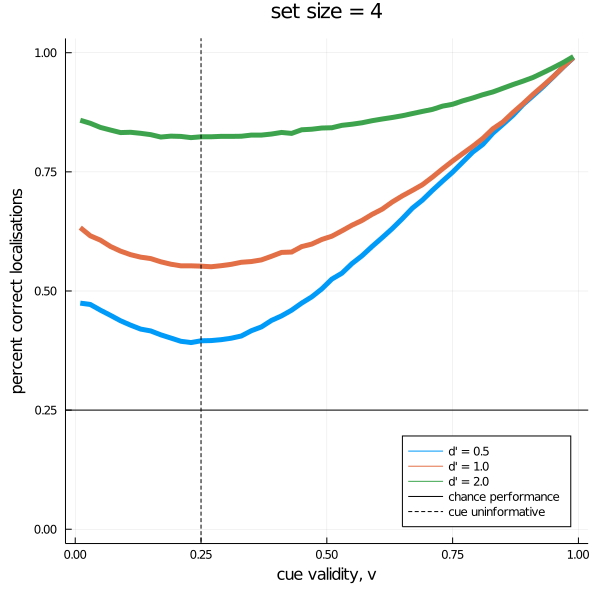

In [6]:
# set up plot
plot(xlabel="cue validity, v", 
    ylabel="percent correct localisations",
    ylim=[0, 1],
    legend=:bottomright,
    size=(600, 600),
    title="set size = $N")

# run simulations for each of the dprime values and plot
for dprime in dprime_list
    σ = 1 / dprime
    pc = simulate(N, cue_validities, σ, trials)
    plot!(cue_validities, pc, lw=5, label="d' = $dprime")
end

hline!([0.25], color=:black, label="chance performance")
vline!([0.25], color=:black, label="cue uninformative", linestyle=:dash)

So this is pretty good. We've replicated the optimal observer predictions in Figure 3 of Vincent (2011) and Figure 8 of Vincent (2015a). While this is very useful, the next step would be to build on this and to estimate the $d'$ of an observer based upon behavioural data.

# References
- Vincent, B. (2011). Covert visual search: Prior beliefs are optimally combined with sensory evidence. Journal of Vision, 11(13), 25-25.
- Vincent, B. T. (2015a). Bayesian accounts of covert selective attention: a tutorial review. Attention, Perception, & Psychophysics, 77(4), 1013-1032.
- Vincent, B. T. (2015b). A tutorial on Bayesian models of perception. Journal of Mathematical Psychology, 66, 103-114.